### Playback walk motion

In [1]:
import time,pickle,mujoco
import numpy as np
import cv2,glob,os
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists,r2rpy,quat2r,slerp,get_A_vel_acc_jerk
import mediapy as media

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse

In [2]:
xml_path = '../asset/atlas_v5/scene_atlas.xml'
env = MuJoCoParserClass(name='MyoSuite',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.9,0.9,0.9,0.5]
print ("Done.")

Done.


In [3]:
for idx, name in enumerate(env.body_names):
    print(idx, name)

0 world
1 pelvis
2 ltorso
3 mtorso
4 utorso
5 head
6 l_clav
7 l_scap
8 l_uarm
9 l_larm
10 l_ufarm
11 l_lfarm
12 l_hand
13 r_clav
14 r_scap
15 r_uarm
16 r_larm
17 r_ufarm
18 r_lfarm
19 r_hand
20 l_uglut
21 l_lglut
22 l_uleg
23 l_lleg
24 l_talus
25 l_foot
26 r_uglut
27 r_lglut
28 r_uleg
29 r_lleg
30 r_talus
31 r_foot


### Load walking motion

In [13]:
pkl_path = '../data/atlas_cmu_walk_recon.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)
qs         = data['qpos'][:,:] # [L * Nj]
# quat_roots = data['rotation'][:,0,:]
xposes      = data['xpos'][:,:]
p_roots     = data['p_root'][:,:]
R_roots     = data['R_root'][:,:] # quaternion
# rotation    = data['rotation'][:,:]
height_offset = 0.3
p_roots[:,2] += height_offset
xposes[:, :, 2] += height_offset
L = qs.shape[0]
SOURCE_HZ = 120
TARGET_HZ = 120
print ("[%s] loaded."%(pkl_path))

[../data/atlas_cmu_walk_recon.pkl] loaded.


In [14]:
def compute_reward(qpos0, qpos1, xpos0, xpos1, rot0, rot1, qvel0, qvel1):
    # rotation of a quaternion error
    rpy0 = np.array([r2rpy(rot) for rot in rot0])
    rpy1 = np.array([r2rpy(rot) for rot in rot1])
    rpy = rpy0 - rpy1
    rpy = np.sum(np.square(rpy))
    rpy = np.exp(-2*rpy)

    # angular velocity error
    qvel = qvel0 - qvel1
    qvel = np.sum(np.square(qvel))
    qvel = np.exp(-0.1*qvel)

    # key point task position error

    # COM error
    root_position = qpos0[...,:3] - qpos1[...,:3]
    root_position = np.sum(np.square(root_position))
    root_position = np.exp(-10*root_position)

    reward = root_position + qvel + rpy

    return reward, {"root_position": root_position, "rpy": rpy, "qvel": qvel}
    # qpos = q0[...,7:] - q1[...,7:]
    # print(q0.shape, q1.shape)

### Extended Ground Truth Created

In [15]:
new_timestep = int(L*TARGET_HZ/SOURCE_HZ)

new_qpos = np.empty((new_timestep,)+qs.shape[1:])
# new_quat = np.empty((new_timestep,)+rotation.shape[1:])
# new_qvel = np.empty((new_timestep,)+qvel.shape[1:])
new_xpos = np.empty((new_timestep,)+xposes.shape[1:])
new_p_roots = np.empty((new_timestep,)+p_roots.shape[1:])
# new_quat = np.empty((new_timestep,)+GT['rotation'].shape[1:])
phase = 0
for i in range(new_timestep):
    phase = np.clip((i/new_timestep), 0, 1)
    frame0 = (int(phase * L))
    frame1 = np.minimum(frame0+1, L-1)
    blend = 1-(phase*L-frame0)
    # new_qpos[i, :3] = p_roots[frame0,] * blend + p_roots[frame1,] * (1-blend)
    # new_qpos[i, 7:] = qs[frame0, 7:] * blend + qs[frame1, 7:] * (1-blend)
    # new_qpos[i, 3:7] = slerp(qs[frame0, 3:7], qs[frame1, 3:7], (1-blend))
    new_qpos[i, :] = qs[frame0, :] * blend + qs[frame1, :] * (1-blend)

    # new_qvel[i] = qvel[frame0] * blend + qvel[frame1] * (1-blend)

    new_p_roots[i] = p_roots[frame0] * blend + p_roots[frame1] * (1-blend)

    new_xpos[i] = xposes[frame0] * blend + xposes[frame1] * (1-blend)

    # new_quat[i] = slerp(rotation[frame0], rotation[frame1], blend)
    
    # print("frame0: {} \nframe1: {}\nphase*origin_timestep: {}\nblend: {}\n".format(frame0,frame1,phase*origin_timestep,phase*origin_timestep-frame0))

# create qvel
temp_qpos = new_qpos.copy()
temp_qpos = np.concatenate((temp_qpos[:,:3],np.array([r2rpy(R) for R in quat2r(temp_qpos[:,3:7])]),temp_qpos[:,7:]),axis=1)
A_vel,A_acc,A_jerk = get_A_vel_acc_jerk(n=temp_qpos.shape[0],dt=1/500)
new_qvel = A_vel @ temp_qpos

print("Extended Ground Truth Created")

Extended Ground Truth Created


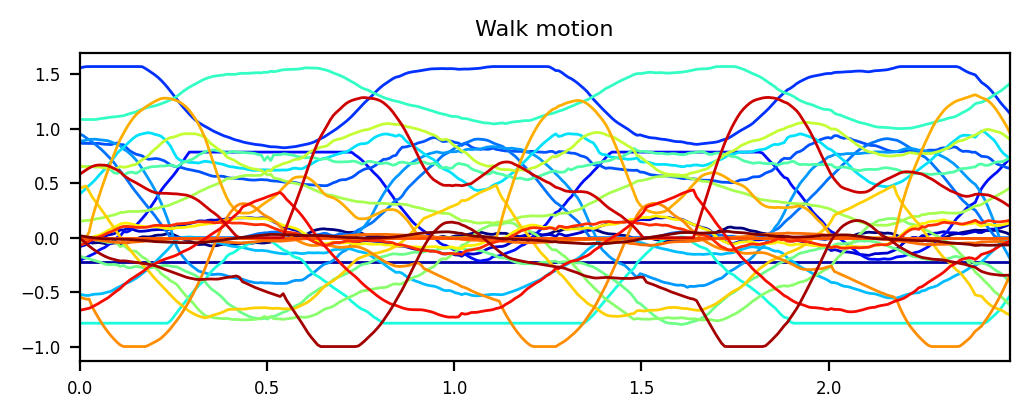

In [16]:
times = np.linspace(0,L/SOURCE_HZ,L)
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,qs.shape[1]))
for i_idx in range(qs.shape[1]):
    plt.plot(times,qs[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([times[0],times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

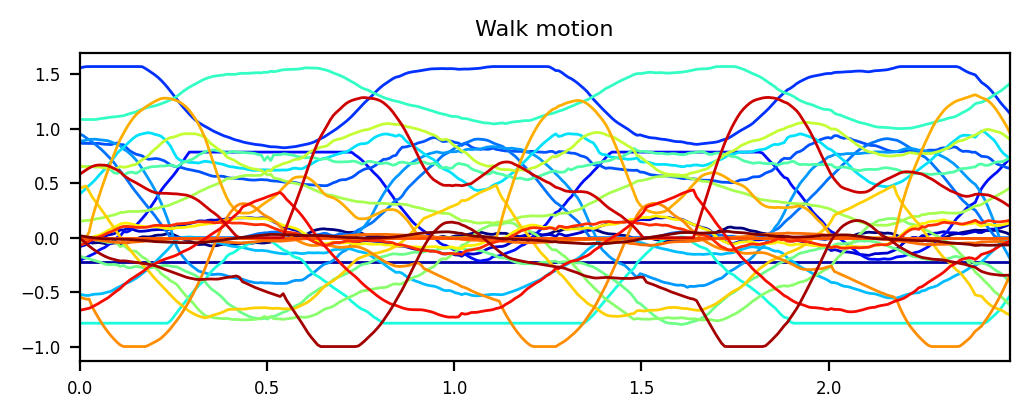

In [17]:
new_times = np.linspace(0,L/SOURCE_HZ,new_timestep)
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,qs.shape[1]))
for i_idx in range(new_qpos.shape[1]):
    plt.plot(new_times,new_qpos[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([new_times[0],new_times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

In [18]:
# Set which joints to control
rev_joint_names = env.rev_joint_names
joint_idxs_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=rev_joint_names)
q_rev_init = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

In [19]:
# n_rev_joint
np.concatenate((env.rev_joint_mins,env.pri_joint_mins)).shape

(30,)

In [20]:
# Configuration
PLOT_EVERY = 4
SAVE_VID   = False
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[4] SAVE_VID:[0]


### Loop

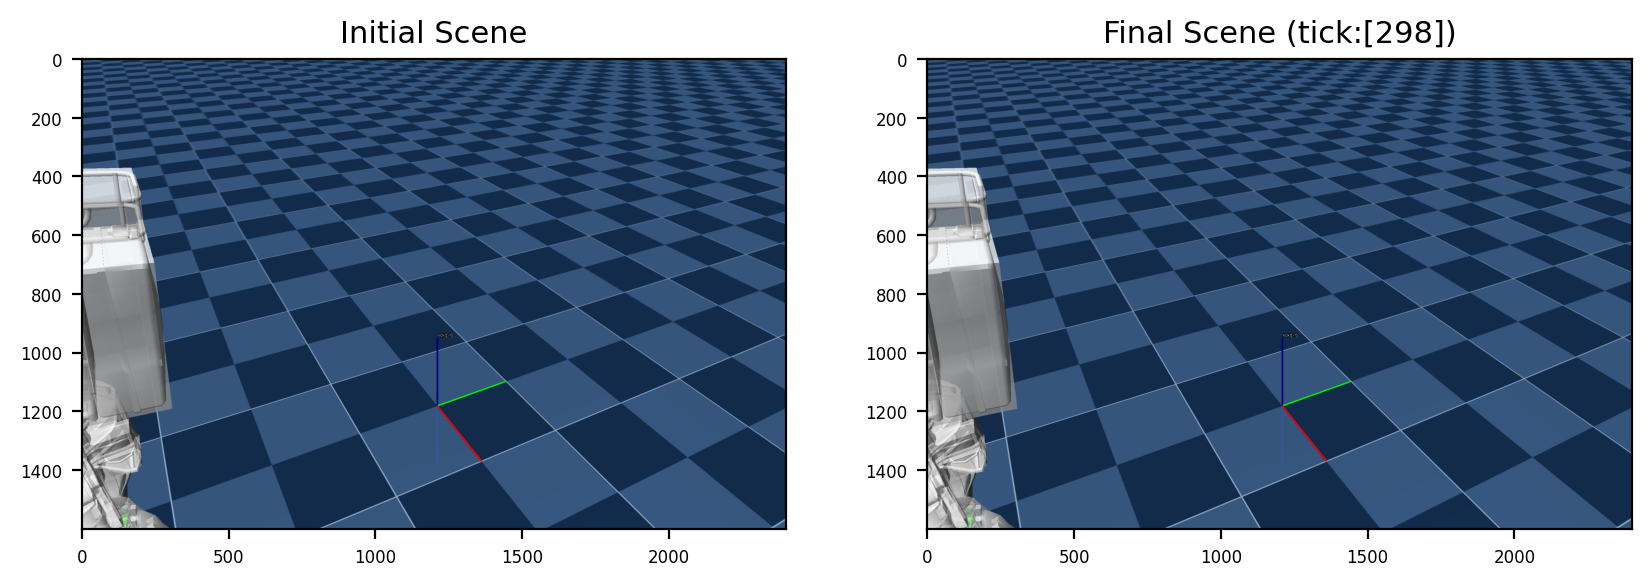

Done.


In [21]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='MyoSuite',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()
FIRST_FLAG = True
root_name = env.data.body(1).name # 'pelvis'
while env.tick < new_timestep:

    # Update
    time.sleep(5e-3) # little delay helps
    tick = (env.tick-1)
    # contact_in_tick = False

    # FK
    q         = new_qpos[tick,:] # [35]
    p_root    = new_p_roots[tick,:] # [3]
    quat_root = R_roots[tick,:] # [4] quaternion
    env.set_p_root(root_name=root_name,p=p_root)
    env.set_quat_root(root_name=root_name,quat=quat_root)
    # env.set_quat_root(root_name='base',quat=)
    env.forward(q=q,joint_idxs=joint_idxs_fwd)
    
    # Reset z position of root
    # while not contact_in_tick and len(env.get_contact_info()[0]) == 0:
    while len(env.get_contact_info()[0]) == 0:
        # print(contact_in_tick, len(env.get_contact_info()[0]))
        p_root[2] -= 0.0001
        new_xpos[tick, :, 2] -= 0.0001
        env.set_p_root(root_name=root_name,p=p_root)
        env.forward(q=q,joint_idxs=joint_idxs_fwd, INCREASE_TICK=False)
        # env.render()
    
    # Update p_roots
    new_p_roots[tick] = p_root
        
    # Render
    if env.loop_every(tick_every=1):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                   PLOT_AXIS=False,label="tick:[%d]"%(tick))
        # Plot foot
        # env.plot_geom_T(geom_name='foot2_right',axis_len=0.3)
        # env.plot_geom_T(geom_name='foot2_left',axis_len=0.3)
        # Plot revolute joints with arrow
        env.plot_joint_axis(axis_len=0.1,axis_r=0.01)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
        scene_img_final = scene_img_init.copy()
        FIRST_FLAG = False
    # if env.is_viewer_alive() and env.loop_every(tick_every=1000):
    #     scene_img_final = env.grab_image()

    if SAVE_VID:
        # Save iamges
        png_path = '../temp/cmu_smplrig_walk_%05d.png'%(env.tick)
        create_folder_if_not_exists(png_path)
        image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
        cv2.imwrite(png_path,image)
    
    # print("timestep {}".format(env.tick))

    
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()
print ("Done.")

In [ ]:
assert new_timestep == new_p_roots.shape[0]
assert new_timestep == new_qpos.shape[0]
assert new_timestep == new_qvel.shape[0]
assert new_timestep == new_xpos.shape[0]
assert new_timestep == new_quat.shape[0]

pkl_data = {
    'length': new_timestep,
    'root': new_p_roots, # Z-position edited
    'qpos': new_qpos, # Z-position not edited 
    'qvel': new_qvel,
    'xpos': new_xpos,
    # 'rotation': new_quat,# Quaternion
}
with open('../data/smplrig_cmu_walk_16_15_zpos_edited.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)
